# Leaf classification
## An experiment on using RandomForestClassifier by scikit-learn on a [leaf dataset from kaggle](https://www.kaggle.com/c/leaf-classification/data)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')



## 1. Loading data

loading the `train.csv` file from the source

* id - leaf id
* species - class of the leaf
* margin, shape, texture - some features

In [66]:
img_folder = os.path.join('images')

In [63]:
table_data = pd.read_csv('train.csv')

In [4]:
print("Number of classes: %d"%table_data.species.nunique())

Number of classes: 99


In [5]:
table_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


## Creating train and test datasets

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
random_seed = 7

In [8]:
labenc = LabelEncoder()
labels = labenc.fit_transform(table_data.species)
x = np.asarray(table_data.ix[:,2:].values)

sss = StratifiedShuffleSplit(n_splits=1, test_size=198, random_state=random_seed)
train_idx, test_idx = next(iter(sss.split(x, labels)))

In [9]:
train_X = x[train_idx]
test_X = x[test_idx]
train_y = labels[train_idx]
test_y = labels[test_idx]

In [10]:
pd.Series(labenc.inverse_transform(labels[test_idx])).nunique()

99

## Loading images
in addition to the features in data, there are 1584 images of all the leaves in the original dataset on kaggle. Here only those coreresponding to the 'train.csv' file on kaggle are loaded. 

In [67]:
from scipy.misc import imresize

all_leaves = []
for i in range(990):
    filepath = os.path.join(img_folder, '{:}.jpg'.format(table_data['id'][i]))
    img = plt.imread(filepath)
    img_resized = imresize(img, (100, 100))
    all_leaves.append(np.ravel(img_resized))
all_leaves = np.asarray(all_leaves)

## 2. Exploration
Using KMeans on the images of leaves, trying to create 99 clusters.

In [12]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=99, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
             precompute_distances='auto', verbose=1, random_state=random_seed, copy_x=True,
             n_jobs=-1, algorithm='auto')
km.fit(all_leaves)

centers = km.cluster_centers_

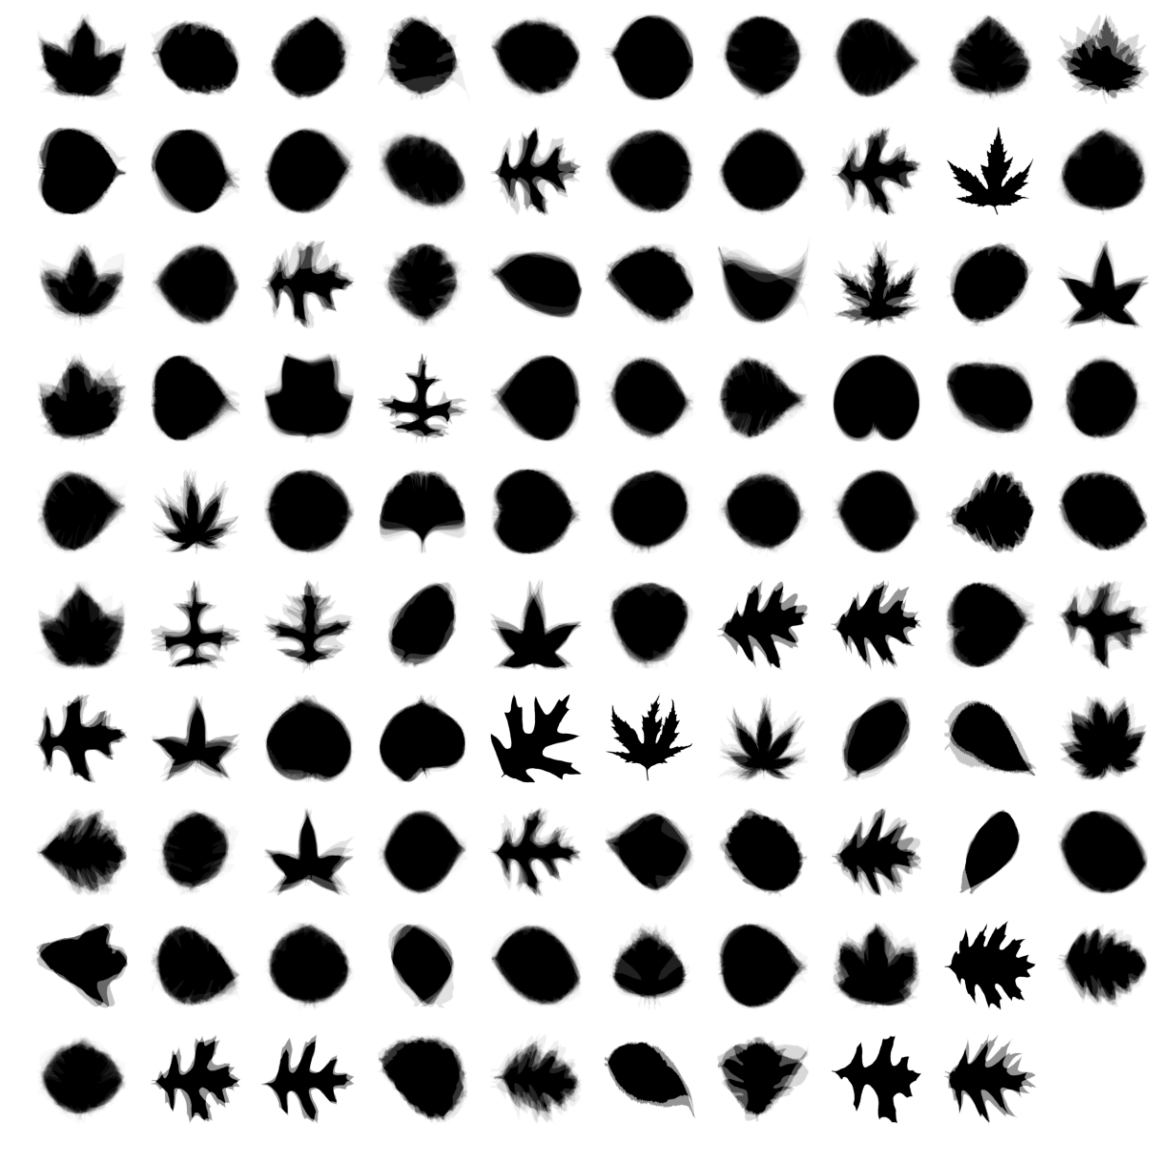

In [13]:
plt.figure(figsize = (20,20))
for j in range(1, 100):
    plt.subplot(10,10,j)
    plt.imshow(centers[j-1].reshape(100,100), cmap='Greys') 
    plt.axis("off")

## 3. Prediction
Predictions with logistic regression model, used as a benchmark

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', tol=0.00001, random_state=random_seed,
                        solver='newton-cg', max_iter=100, multi_class='multinomial',
                       verbose=1, n_jobs=-1)

lr.fit(train_X, train_y)
lr.score(train_X, train_y)


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


0.67045454545454541

In [15]:
lr_pr = lr.predict(test_X)
err = (lr_pr != test_y).sum()
100*err/len(test_y)

36.363636363636367

In [16]:
lr.score(test_X, test_y)

0.63636363636363635

## Random forest
The main method to be used in this experiment.
Criterion = 'entropy' achieves ~10% gain in score on the test dataset, compared to the other option, 'gini'.

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5,
                       bootstrap=True, n_jobs=-1, random_state=random_seed, verbose=1)
rf.fit(train_X, train_y)
rf.score(train_X, train_y)


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.97979797979797978

In [24]:
rf_pr = rf.predict(test_X)
err = (rf_pr != test_y).sum()
100*err/len(test_y)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


9.5959595959595951

In [25]:
rf.score(test_X, test_y)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


0.90404040404040409

## 4. Feature engeneering and selection

The performance above is already quite good. Next is to examine if the ensemble overfits. For this, trying to reduce dimentionality of data with PCA and SelectKBest and examining the performance of the ensemble can be done.

### PCA

In [26]:
from sklearn.decomposition import PCA
num_components = [2, 8, 32, 64, 128]
train_score = np.zeros(len(num_components))
test_score = np.zeros(len(num_components))

In [29]:

for i,item in enumerate(num_components):
    print(i)
    pca = PCA(n_components=item, svd_solver='auto', random_state=random_seed)
    pca.fit(x)
    transf_train = pca.transform(train_X)
    transf_test = pca.transform(test_X)
    forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5,
                       bootstrap=True, n_jobs=-1, random_state=random_seed, verbose=0)
    forest.fit(transf_train, train_y)
    train_err = forest.score(transf_train, train_y)
    test_err = forest.score(transf_test, test_y)
    train_score[i] = train_err
    test_score[i] = test_err


0
1
2
3
4


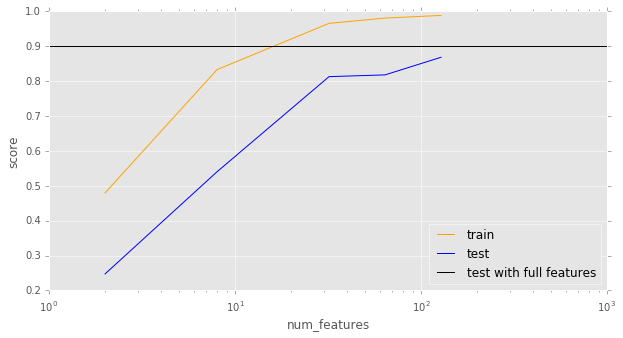

In [32]:
plt.figure(figsize=(10,5))
plt.plot(num_components, train_score, color='orange', label='train')
plt.plot(num_components, test_score, color='blue', label='test')
plt.axhline(0.9, color='black', label='test with full features')
plt.xlabel('num_features')
plt.ylabel('score')
plt.legend(loc=0)
plt.xscale("log")

### SelectKBest

In [38]:
from sklearn.feature_selection import SelectKBest

In [39]:
features = SelectKBest(k=100)
features.fit(x,labels)
x_reduced = features.transform(train_X)
x_test_reduced = features.transform(test_X)

In [40]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=5,
                       bootstrap=True, n_jobs=-1, random_state=random_seed, verbose=0)
forest.fit(x_reduced, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

In [41]:
forest.score(x_reduced, train_y)


0.93939393939393945

In [42]:
forest.score(x_test_reduced, test_y)

0.79797979797979801

Using both methods for dimensionality reduction decreased the performance on the test dataset. All the features will be used, but the best classifier is still to be found

## 5. Hyperparameters tuning
Grid search over 25 ensembles with varying number of trees and individual tree depth

In [45]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators' : [10, 30, 70, 100, 130],
            'max_depth' : [1, 2, 3, 5, 7]
             }
gs = GridSearchCV(estimator=RandomForestClassifier(criterion = 'entropy', random_state= random_seed),
                  param_grid = param_grid, scoring='accuracy', n_jobs=-1, cv=4, verbose=1)
gs.fit(train_X, train_y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 70, 100, 130], 'max_depth': [1, 2, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [46]:
best_forest = gs.best_estimator_
best_forest.score(test_X, test_y)

0.9494949494949495

In [68]:
best_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

A forest with 100 trees of depth 7 seems to give best performance on test dataset with ~95% accuracy score

Plotting each leaf that was classified wrong and a sample leaf from the class it was mistakingly assigned to. Some leaves could indeed be easily confused, while other mistakes seem obvious to a human observer.

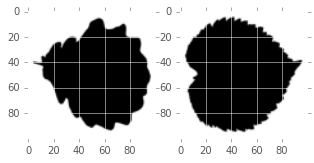

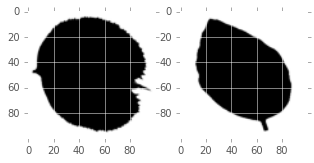

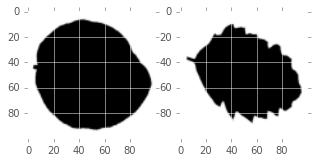

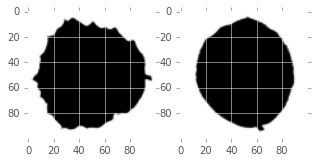

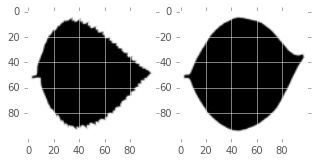

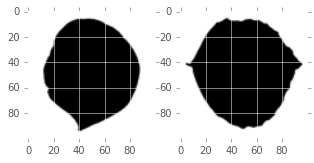

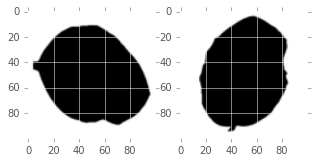

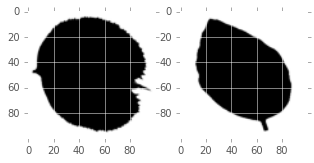

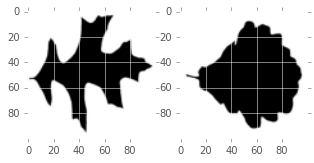

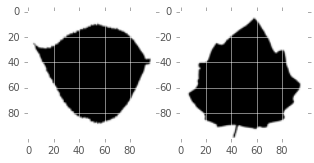

In [57]:
pr = pd.Series(best_forest.predict(test_X))
wrong = np.asarray(pr[pr.values != test_y])
for item in wrong:
    plt.figure(figsize=(5,3))
    plt.subplot(1,2,1)
    plt.imshow(all_leaves[item].reshape(100,100), cmap='Greys')
    plt.subplot(1,2,2)
    lbls = pd.Series(labels)
    index = lbls[lbls == item].index[0]
    plt.imshow(all_leaves[index].reshape(100,100), cmap='Greys')